# Data Visualization

### Objectives

* Answer business requirement 1 :
    - The client seeks to undertake a study aimed at visually differentiating healthy bones from fractured ones.

### Inputs

* inputs/fracture_dataset/bone_fracture/bone_fracture/test
* inputs/fracture_dataset/bone_fracture/bone_fracture/train
* inputs/fracture_dataset/bone_fracture/bone_fracture/val

### Outputs

* Scatterplot of the image shape.
* Mean and variability of images per label plot.
* Plot to distinguish contrast between healthy bone and fractured bone images.
* Generate code that answers business requirement 1 and can be used to build image montage on Streamlit dashboard.

---

# Set Data Directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set Working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/Bone-Fracture-Detection/jupyter_notebooks'

In [3]:
os.chdir('/workspace/Bone-Fracture-Detection')

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Bone-Fracture-Detection'

### Set input directory

In [5]:
parent_path = 'inputs/fracture_dataset/bone_fracture/bone_fracture'
train_path = parent_path + '/train'
val_path = parent_path + '/val'
test_path = parent_path + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
	print('Old version is already available create a new version.')
	pass
else:
	os.makedirs(name = file_path)

Old version is already available create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('Folders inside the train test and val folders are :', labels)

Folders inside the train test and val folders are : ['fractured', 'unfractured']


---

# Data visualisation of bone fracture data

### Scatterplot with average image size

Calculates the average size of the images in the training set, then plots it into a scatterplot for better visualisation.

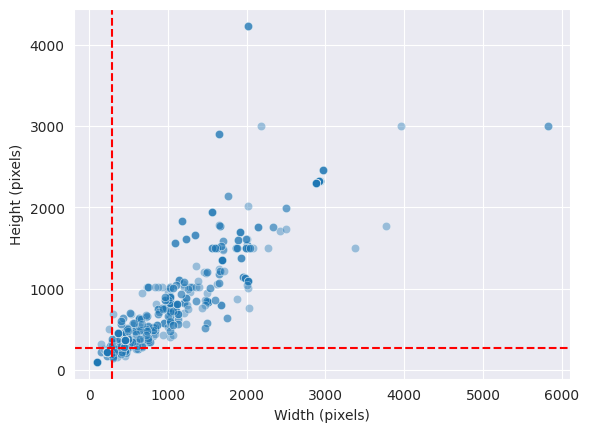

Width average: 273 
Height average: 290


In [8]:
x_dim, y_dim = [], []
for label in labels:
	for image_name in os.listdir(train_path + '/' + label):
		img = imread(train_path + '/' + label + '/' + image_name)
		dx, dy, colors = img.shape
		x_dim.append(dx)
		y_dim.append(dy)


sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=x_dim, y=y_dim, alpha=0.4)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
x_dim_mean = int(np.array(x_dim).mean())
y_dim_mean = int(np.array(y_dim).mean())
axes.axhline(y=y_dim_mean, color='r', linestyle='--')
axes.axvline(x=x_dim_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {y_dim_mean} \nHeight average: {x_dim_mean}")

Stores the average image size in a variable.

In [9]:
mean_image = (x_dim_mean, y_dim_mean, 3)
mean_image

(290, 273, 3)

Saves the variable in the output folder

In [10]:
joblib.dump(value=mean_image, filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

# Mean and Variability of the images

This function creates empty arrays then loads the images with the new image size then appends the new images into the empty arrays.

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(data_dir, new_size=(50,50), n_images_per_label = 20):
	X, y = np.array([], dtype='int'), np.array([], dtype='object')
	labels = os.listdir(data_dir)

	for label in labels:
		counter = 0
		for image_filename in os.listdir(data_dir + '/' + label):
			if counter < n_images_per_label:
				img = image.load_img(data_dir + '/' + label + '/' + image_filename, target_size=new_size)
				if image.img_to_array(img).max() > 1: 
					img_resized = image.img_to_array(img) / 255
				else: 
					img_resized = image.img_to_array(img)
				
				X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
				y = np.append(y, label)
				counter += 1

	return X, y

Loads the mean image shape and labels in an array

In [12]:
X, y = load_image_as_array(data_dir=train_path,
                           new_size=mean_image,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 290, 273, 3) (60,)


Plot and save mean and variability of images per label. This function loops through the labels, then subsets an array for a given label, then calculates the mean and standard deviation, then creats a figure showing the mean and variability of the images, and saves the image.

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
	for label_to_display in np.unique(y):
		sns.set_style('white')

		y = y.reshape(-1,1,1)
		boolean_mask = np.any(y==label_to_display, axis=1).reshape(-1)
		arr = X[boolean_mask]

		avg_img = np.mean(arr, axis = 0)
		std_img = np.std(arr, axis = 0)
		print(f'==== Label {label_to_display} ====')
		print(f'Image Shape: {avg_img.shape}')
		fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
		axes[0].set_title(f'Average Image for label {label_to_display}')
		axes[0].imshow(avg_img, cmap='gray')
		axes[1].set_title(f'Variability image for label {label_to_display}')
		axes[1].imshow(std_img, cmap='gray')

	if save_image:
		plt.savefig(f'{file_path}/avg_var_{label_to_display}.png', bbox_inches='tight', dpi=150)
	else:
		plt.tight_layout()
		plt.show()
		print('\n')

==== Label fractured ====
Image Shape: (290, 273, 3)
==== Label unfractured ====
Image Shape: (290, 273, 3)


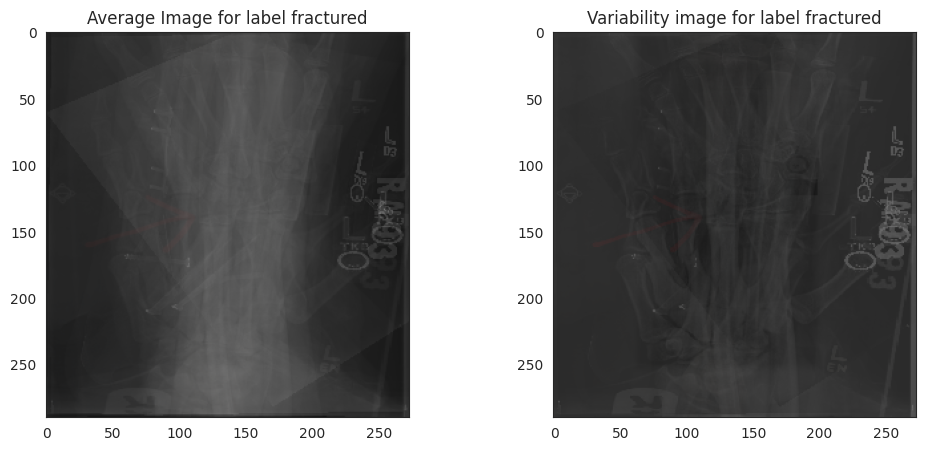

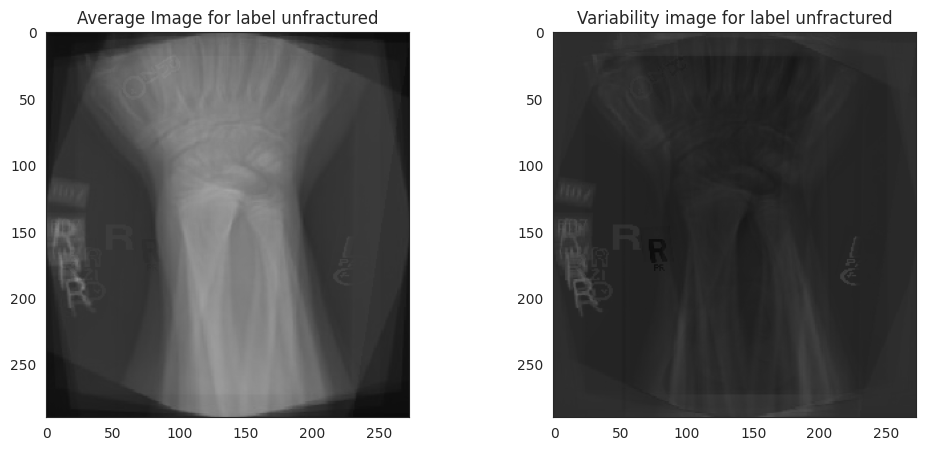

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5), save_image=True)

---

# Difference between average fractured and not fractured images

The first function subsets the image data and labels based on a specific label. It returns a subset of image data corresponding to the specified label.

The second function checks if the labels exist, then it calculates the mean and difference for the labels and plots a chart then saves it if save_image=True.

In [15]:
def subset_image_label(X, y, label_to_display):
	y = y.reshape(-1,1,1)
	boolean_mask = np.any(y==label_to_display, axis=1).reshape(-1)
	df = X[boolean_mask]
	return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
	if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
		print(f'Either label {label} or label {label_2}, are not in {np.unique(y)}')
		return

	images_label = subset_image_label(X, y, label_1)
	label1_avg = np.mean(images_label, axis = 0)

	images_label = subset_image_label(X, y, label_2)
	label2_avg = np.mean(images_label, axis = 0)

	difference_mean = label1_avg - label2_avg
	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
	axes[0].imshow(label1_avg, cmap='gray')
	axes[0].set_title(f'Average {label_1}')
	axes[1].imshow(label2_avg, cmap='gray')
	axes[1].set_title(f'Average {label_2}')
	axes[2].imshow(difference_mean, cmap='gray')
	axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
	if save_image:
		plt.savefig(f'{file_path}/avg_diff.png', bbox_inches='tight', dpi=150)
	else:
		plt.tight_layout()
		plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


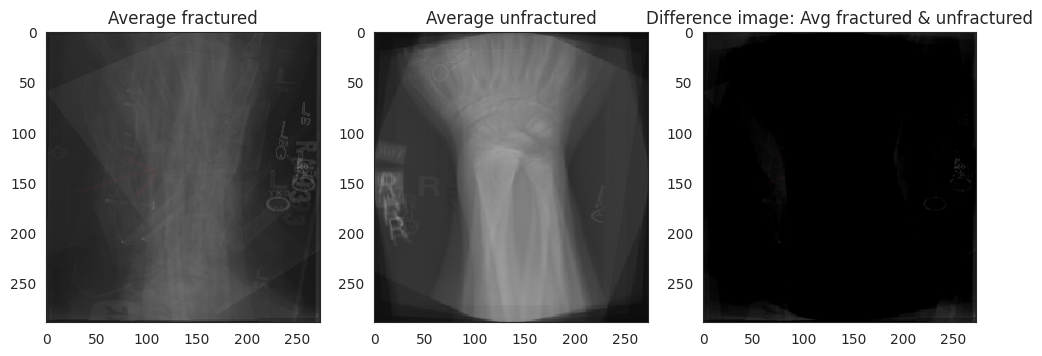

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='fractured', label_2='unfractured',
                                        figsize=(12,10),
                                        save_image=True
                                        )

---

# Image Montage

This function checks if label exists in the folder. Then checks if your montage space is greater than subset size. Then creates a list of axes indices based on nrows and ncols. And creates a Figure and displays images.

In [20]:
import itertools
import random


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15,10)):
	labels = os.listdir(dir_path)

	if label_to_display in labels:
		images_list = os.listdir(dir_path +'/'+ label_to_display)
		if nrows * ncols < len(images_list):
			img_idx = random.sample(images_list, nrows * ncols)
		else:
			print(
				f'Decrease nrows or ncols to create your montage. \n'
				f'There are {len(images_list)} in your subset. \n'
				f'You requested a montage with {nrows * ncols} spaces')
			return

		list_rows= range(0, nrows)
		list_cols= range(0, ncols)
		plot_idx = list(itertools.product(list_rows, list_cols))

		fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
		for x in range(0, nrows * ncols):
			img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
			img_shape = img.shape
			axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
			axes[plot_idx[x][0], plot_idx[x][1]].set_title(f'Width {img_shape[1]}px x Height {img_shape[0]}px')
			axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
			axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
		plt.tight_layout()
		plt.show()

	else:
		print('The label you selected doesnt exist.')
		print(f'The existing options are: {labels}')

fractured


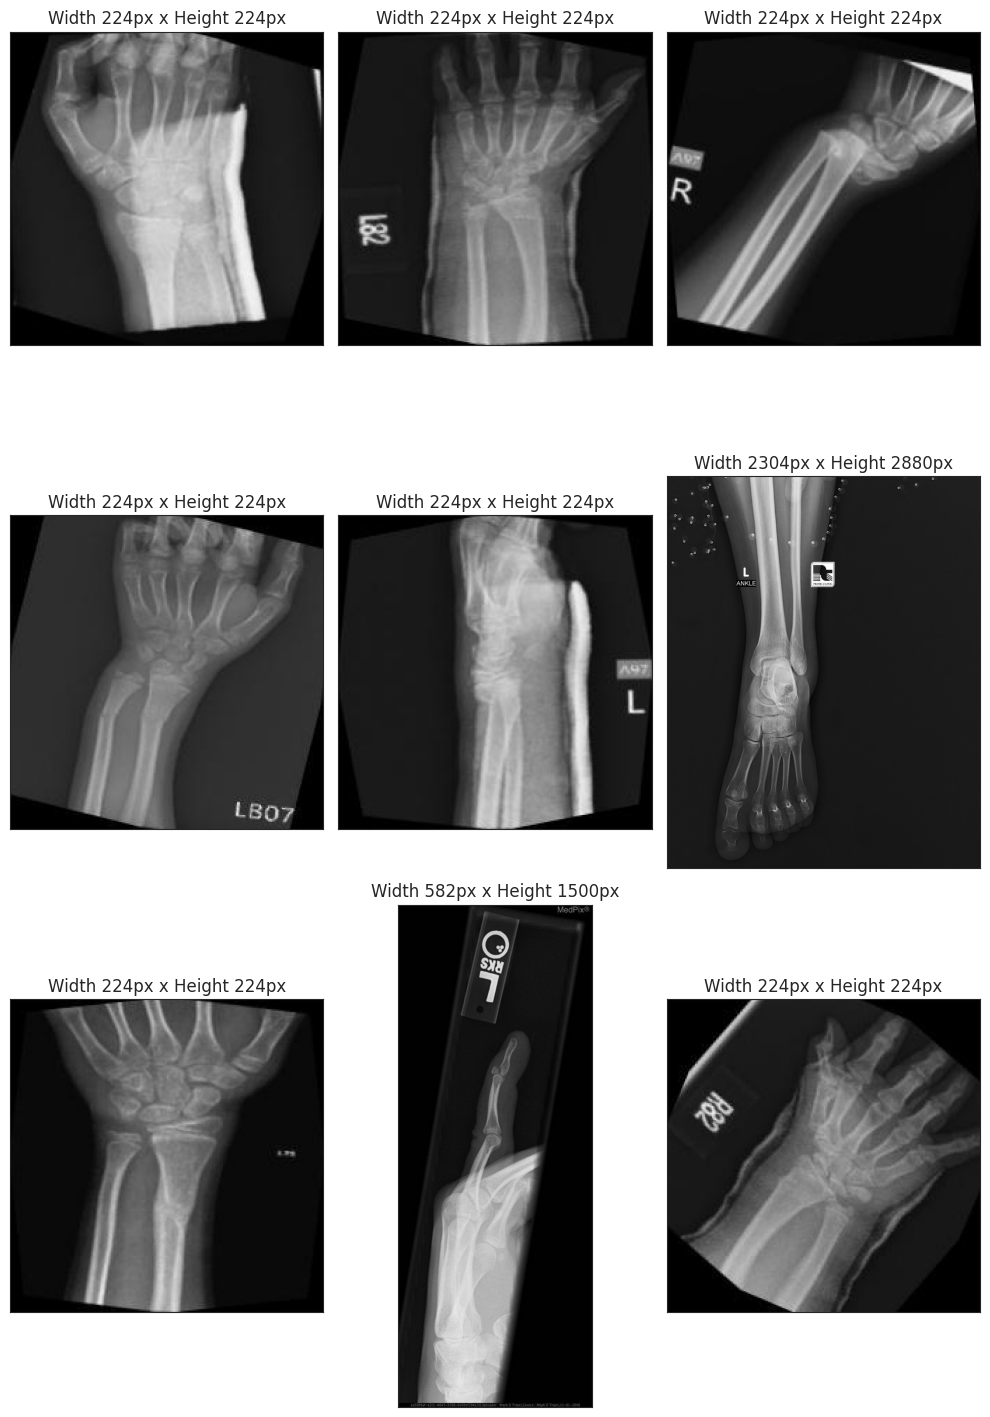



unfractured


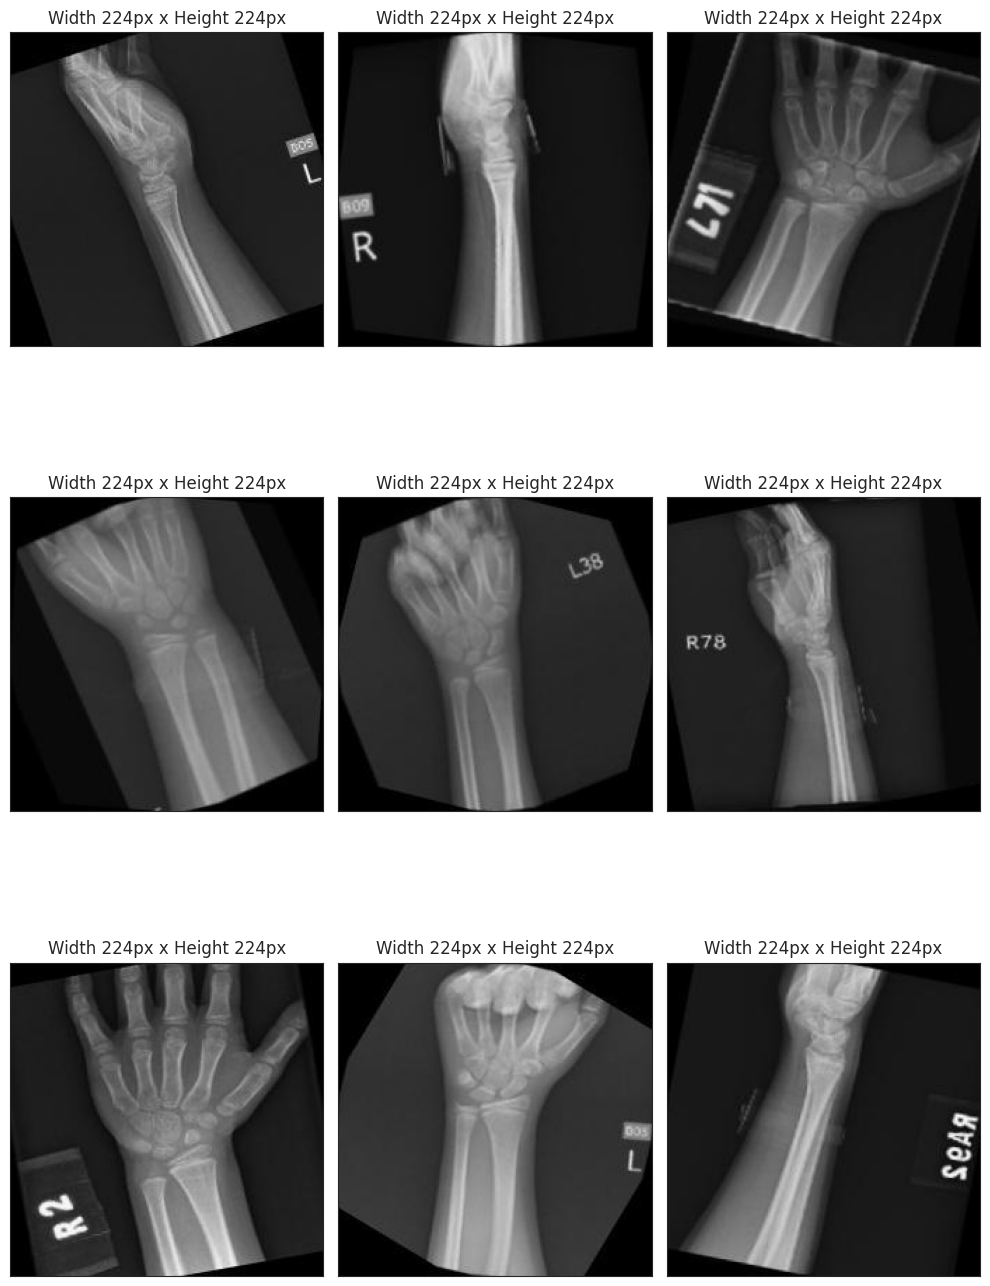

In [21]:
for label in labels:
	print(label)
	image_montage(dir_path=train_path,
				label_to_display=label,
				nrows=3, ncols=3,
				figsize=(10, 15)
				)
	print('\n')

---

# Conclusions and Next Steps

- Image shape was created using the average height and width.

- Mean, variability and difference images were generated.

- Image montage was created.

- The fractured bones are distinguishable from healthy bones by their appearance.

- The next step is data modelling.